In [1]:
%pylab inline

from xgboost.sklearn import XGBClassifier
from typing import Tuple
import xgboost as xgb
import pandas as pd
import json
import sklearn
from sklearn import model_selection

dataset = pd.read_csv('data/multisession-eeg.csv')
fromstring = lambda array_str: np.fromstring(array_str, dtype=float, sep=',')
dataset.raw_fft = dataset.raw_fft.apply(fromstring)
# dataset.raw_fft.iloc[0]

Populating the interactive namespace from numpy and matplotlib


//anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
dataset.head()

,time,subject,session,label,raw_fft
0,2017-07-22T20:37:13.267775811Z,A,0,unlabeled,"[10.3113040924, 14.77069664, 12.213514328, 9.7..."
1,2017-07-22T20:37:14.253040444Z,A,0,unlabeled,"[11.2151269913, 14.9568557739, 10.8369417191, ..."
2,2017-07-22T20:37:15.372317746Z,A,0,unlabeled,"[6.34600162506, 12.5924711227, 10.8416910172, ..."
3,2017-07-22T20:37:16.483798739Z,A,0,unlabeled,"[10.0782966614, 16.9934558868, 18.5345039368, ..."
4,2017-07-22T20:37:17.471855277Z,A,0,unlabeled,"[4.42960739136, 9.05199050903, 4.41912555695, ..."


In [3]:
dataset['subject'].unique(),dataset['label'].unique()

(array(['A', 'B', 'C'], dtype=object),
 array(['unlabeled', 'breathe', 'song', 'song_o', 'sport', 'breathe_o',
        'speech', 'face', 'calibration', 'word_x', 'phrase_x', 'face_x',
        'breatheopen', 'song_x', 'sport_x', 'breatheclosed', 'word_c',
        'phrase_c', 'face_c', 'song_c', 'sport_c'], dtype=object))

# Passthoughts

What if you could simply *think your password*? That's the premise behind *passthoughts*. We'll discuss passthoughts in more depth in lecture 3, but for now, we'll lay this out as a classification problem:

> Given a reading, and a person, is that person who they claim to be?

We'll structure this problem as follows: For each subject, we'll train a classifier. That subject's readings will be positive example, and everyone else's readings will be negative examples.

We can make this a little fancier by having people use specific thoughts (e.g. "focus on your breathing," "sing a song in your head," etc). We'll make sure our methods can handle this case, but for the time being, we'll just use the `"unabeled"` readings - people doing nothing in particular.

We'll use subject `A` as our "target" individual. We will train on this subject for this assignment, and train against the other subjects in the corpus (subjects `B` and `C`).

In [4]:
def to_matrix (series):
    return np.array([ x for x in series ])

def readings_right_subject_right_task (subj, task, session=0):
    return to_matrix(dataset[
        (dataset['subject'] == subj) &
        (dataset['label'] == task) &
        (dataset['session'] == session)
    ].raw_fft)

def readings_wrong_subj_any_task (subj):
    return to_matrix(dataset[
        (dataset['subject'] != subj)
    ].raw_fft)

In [5]:
positive = readings_right_subject_right_task('A', 'unlabeled', 0)
negative = readings_wrong_subj_any_task('A')
positive.shape, negative.shape

((40, 516), (1228, 516))

## TODO

Notice how we structured our positive and negative examples:

- *Positive examples*: The right person thinking the right task.

- *Negative examples*: The wrong person thinking any task (whether it is right or wrong).

In the context of passthoughts, consider other possibilites for selecting positive and negative features. Here, (1) pick one configuration of positive and negative examples, aside from the ones listed, and (2) discuss their possible consequences (pros/cons). Explain how you might evaluate this selection (with data, with user experiments, etc - your choice).

#### *Your answer here...*

Another possible configuration of positive and negative examples is:
- *Positive example*:*: The right person thinking any task
- *Negative examples*: The wrong person thinking any task (whether it is right or wrong) 

This configuration puts the emphasis on the subject rather than the password. It assumes that it is more important to authenticate the right person(regardless of what passthought they have) than to always have a correct password/passthought presented.In a way, this configuration undermines the knowledge factor while primarily focussing on the inherence factor.
 
##### Explain how you might evaluate this selection (with data, with user experiments, etc - your choice).

Now, we'll turn these data into our feature/label matrices `X` and `y`.

In [6]:
X = np.concatenate([positive, negative])

In [7]:
y = np.array([ 0 for x in positive] + [ 1 for x in negative])
assert X.shape[0] == y.shape[0]

Note that we are assigning `0` to "positive" examples, and `1` to "negative" examples. That means `0` will mean "ACCEPT" and `1` will mean "REJECT."

## TODO

Now, train and test a classifier! Estimate your classifier's accuracy.

In [8]:
# Your code here....

def fresh_clf () -> XGBClassifier:
    return XGBClassifier(
        # Don't worry about those parameters for now,
        # though feel free to look them up if you're interested.
        objective= 'binary:logistic',
        seed=27)

def xgb_cross_validate (
    X: np.array,
    y: np.array,
    nfold: int=7
) -> Tuple[XGBClassifier, pd.DataFrame]:
    # eval_metrics:
    # http://xgboost.readthedocs.io/en/latest//parameter.html
    metrics = ['error@0.1', 'auc']
#     metrics = [ 'auc' ]
    # we use the @ syntax to override the default of 0.5 as the threshold for 0 / 1 classification
    # the intent here to to minimize FAR at the expense of FRR
    alg = fresh_clf()
    xgtrain = xgb.DMatrix(X,y)
    param = alg.get_xgb_params()
    cvresults = xgb.cv(param,
                      xgtrain,
                      num_boost_round=alg.get_params()['n_estimators'],
                      nfold=nfold,
                      metrics=metrics,
                      early_stopping_rounds=100
                      )
    alg.set_params(n_estimators=cvresults.shape[0])
    alg.fit(X,y,eval_metric=metrics)
    return alg, cvresults

In [9]:
X_train, X_validate, y_train, y_validate = model_selection.train_test_split(
    X, y, 
    test_size=0.33, 
    random_state=42)

clf, cvres = xgb_cross_validate(X_train, y_train)

In [10]:
clf.score(X_validate, y_validate)

0.98329355608591884

For authentication, what we want even more than "accuracy" here are two metrics:

- False Acceptance Rate (FAR): The percentage of readings *not* from subject A incorrectly classified "ACCEPT."
- False Rejection Rate (FRR): The percentage of readings *from* subject A incorrectly classified 'REJECT."

For authentication /security/, we want FAR to be as low as possible (so nobody can break in).
For authentication /usability/, we want FRR to be low (so user's don't get frustrated constantly re-trying their passthought).

In [11]:
def far_frr (classifier, features, labels):
    # predict all the labels
    y_pred = classifier.predict(features)
    false_accepts = 0
    false_rejects = 0
    for predicted, actual in zip(y_pred, labels):
        # if we should have rejected,
        # but in fact accepted,
        if (actual == 1) and (predicted == 0):
            # increment false accepts
            false_accepts += 1
        # if we should have accepted,
        # but in fact rejected,
        if (actual == 0) and (predicted == 1):
            # increment false rejections
            false_rejects += 1
    # calculate proportions for each
    far = false_accepts / len(list(filter(lambda x: x ==0,y_pred)))
    frr = false_rejects / len(list(filter(lambda x: x ==1,y_pred)))
    return far, frr

In [12]:
far, frr = far_frr(clf, X_validate, y_validate)
#'FAR: {far} - FRR: {frr}'
far,frr

(0.3, 0.009779951100244499)

Now, these results might be good. 

But our classifier's accuracy could be misleading.   

Can you see why? 

Two reasons why our classifier might be misleading:
- The number of training examples for the positive-negative classes are 40-1228 (1:~30) in the example above. 

- This classifier is not explicitly trained on readings of the right person thinking the wrong thing. These readings can easily be treated as positive or negative depending on viewpoint:

   An approach that assumes that the knowledge factor is more important(knowledge-centric approach), might assert that the right person with the wrong password is always rejected. Alternatively, an inherence-centric viewpoint would treat such examples as positive examples where the right person is always accepted. This ambiguity could perhaps explain the FAR to a small degree.
   
I test this hypothesis below:
###### 1. inherence-centric viewpoint
Here, I assume the configuration:
- Positive example:*: The right person thinking any task.
- Negative examples: The wrong person thinking any task

Assumption: What if the passthought was not needed?

In [13]:
#generic function for training and checking frr given positive and negative examples
def train_check_far_frr(positive,negative):
    #Check dimensions
    positive.shape, negative.shape
    print('positive examples: ', positive.shape,' negative examples: ', negative.shape)

    #Train a classifier
    X = np.concatenate([positive, negative])
    y = np.array([ 0 for x in positive] + [ 1 for x in negative])
    assert X.shape[0] == y.shape[0]
    X_train, X_validate, y_train, y_validate = model_selection.train_test_split(X, y, test_size=0.33, random_state=42)
    clf, cvres = xgb_cross_validate(X_train, y_train)
    print('\nOur classifier has an accuracy of: ',clf.score(X_validate, y_validate))

    #Check FAR and FRR
    far, frr = far_frr(clf, X_validate, y_validate)
    print('\nFAR:', far,' FRR: ',frr)
    
def readings_right_subj (subj):
    return to_matrix(dataset[
        (dataset['subject'] == subj)
    ].raw_fft)


positive = readings_right_subj('A')
negative = readings_wrong_subj_any_task('A')

train_check_far_frr(positive,negative)

positive examples:  (1552, 516)  negative examples:  (1228, 516)

Our classifier has an accuracy of:  0.99128540305

FAR: 0.011627906976744186  FRR:  0.004975124378109453


In the example above, I assume the configuration:
- *Positive example*:*: The right person thinking any task. 
- *Negative examples*: The wrong person thinking any task 



###### 2. knowledge-centric viewpoint
Here, I assume the configuration:
- Positive example:*: The right person thinking the right task.
- Negative examples: The wrong person thinking any task + right person thinking the wrong task 

In [14]:
def readings_right_subject_wrong_task (subj, task, session=0):
    return to_matrix(dataset[
        (dataset['subject'] == subj) &
        (dataset['label'] != task) &
        (dataset['session'] == session)
    ].raw_fft)

positive = readings_right_subject_right_task('A', 'unlabeled', 0)
negative = np.concatenate([readings_wrong_subj_any_task('A'),readings_right_subject_wrong_task('A', 'unlabeled')])

train_check_far_frr(positive,negative)


positive examples:  (40, 516)  negative examples:  (1410, 516)

Our classifier has an accuracy of:  0.983298538622

FAR: 1.0  FRR:  0.014644351464435146


This approach performs way worse than all other configurations seen so far. Shockingly, the FAR is at 100% (everyone who was accepted was a fraud!!). This could potentially be attributed to the overwhelming number of negative examples. To handle this, I reduce the number of negative examples by shuffling and slicing the matrix.

In [15]:
#Shuffle and slice the negative examples so that the training set is not too unbalanced.
np.random.shuffle(negative)
neg = negative[0:50,:]
train_check_far_frr(positive,neg)

positive examples:  (40, 516)  negative examples:  (50, 516)

Our classifier has an accuracy of:  0.8

FAR: 0.1  FRR:  0.25


Although the FAR reduces the classifier's accuracy drops significantly. Overall this could mean that the knowledge factor is not as important in authenticating users as the inherence factor.

# Nonstationarity

We are training, and testing, using data recorded over a single session. As we know, EEG changes over time, a property known as *nonstationarity*. Will our great results still hold a few weeks later?

Let's take subject `A`'s data from sessions 1 and 2, which were recorded a few weeks after session 0.

In [16]:
X_subja_sess1 = readings_right_subject_right_task('A', 'unlabeled', 1)
X_subja_sess2 = readings_right_subject_right_task('A', 'unlabeled', 2)
X_subja_later = np.concatenate([X_subja_sess1, X_subja_sess2])
y_subja_later = [ 0 for x in X_subja_later ]

Now, let's try the classifier we trained on the original data, testing it on the later data.

In [17]:
far, frr = far_frr(clf, X_subja_later, y_subja_later)
#f'FAR: {far*100}% - FRR: {frr*100}%'
far,frr

(0.0, 1.0)

As we will discuss more in lecture 3, this is a problem for us. After all, we can calibrate our target subject, but we then expect them to leave the lab and go use the device later on. If their state changes so much that they can no longer be authenticated, we can't very well claim our system is accurate!

## TODO

The crux of the lab focuses on nonstationarity. At minimum, your mission is to quantify and qualify *what* is changing in EEG signals over time. You may use any tools in answering this question.

You also have your choice of corpus:

- Study subject `A`'s recordings over the three sessions provided here.
- Study one subject's recordings over the course of a year.

You can use both of these corpora, if you would like.

Some questions to spur investigation:

- What features of readings cause a classifier that works on earlier recordings fail on later ones?
- What features remain the same? Are there any?
- What might be the source of these changing features? Changing placement in the EEG device? Changing properties of the brain?

Please note below all work you do, and any notes you make along the way. Ideally, your work should read like a story - words (and questions!) interspersed with code. Good luck, and have fun!

#### Approach
1. PCA analysis on Study subject `A`'s recordings over the three sessions 
2. Time and Frequency charts on the longitudinal data over one week

#### 1. PCA analysis

PCA is a common dimensionality reduction technique that is also used for clustering. I used it in this case, since I wasn't sure what element of the signals stayed the same or changed over time

In [18]:
#importations
print(__doc__)
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


#Prepare the data
X_subja_sess1 = readings_right_subject_right_task('A', 'unlabeled', 0)
X_subja_sess2 = readings_right_subject_right_task('A', 'unlabeled', 1)
X_subja_sess3 = readings_right_subject_right_task('A', 'unlabeled', 2)
y_subja_sess1 = [ 0 for x in X_subja_sess1 ]
y_subja_sess2 = [ 1 for x in X_subja_sess2 ]
y_subja_sess3 = [ 2 for x in X_subja_sess3 ]
X = np.concatenate([X_subja_sess1, X_subja_sess2,X_subja_sess3])
y = np.concatenate([y_subja_sess1,y_subja_sess2,y_subja_sess3])
X.shape,y.shape

Automatically created module for IPython interactive environment


((656, 516), (656,))

explained variance ratio (first two components): [ 0.71564019  0.09552565]


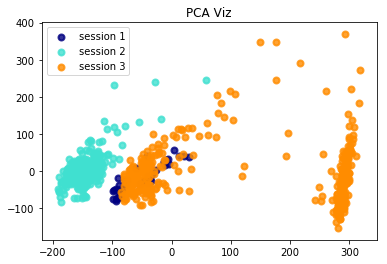

In [70]:
#initialize variables
n_components=2
colors = ['navy', 'turquoise', 'darkorange']
target_names = ['session 1','session 2','session 3']


def plot_PCA(X,y,target_names,n_components,colors):
    pca = PCA(n_components)
    X_r = pca.fit(X).transform(X)
    # Percentage of variance explained for each components
    print('explained variance ratio (first two components): %s'
          % str(pca.explained_variance_ratio_))
    plt.figure()
    lw = 2
    for color, i, target_name in zip(colors, [0, 1, 2], target_names):
        plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                    label=target_name)
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title('PCA Viz')
    plt.figure()


plot_PCA(X,y,target_names,n_components,colors)
#plt.show()

#### Findings
- Nonstationarity seems not to be a big issue between sessions 1 and 3, apart from the strange cluster on the right.  
- User A in sessions 2 seems to be significantly different from the other sessions though. 

#### 2. Longitudinal data over one week
I plotted the time and frequency domain graphs for unlabeled, math and music tasks

In [71]:

#Read one week worth of data
dataset0 = pd.read_csv('data/longitudinal-packaged/labeled/0.csv')
dataset1 = pd.read_csv('data/longitudinal-packaged/labeled/1.csv')
dataset2 = pd.read_csv('data/longitudinal-packaged/labeled/2.csv')
dataset3 = pd.read_csv('data/longitudinal-packaged/labeled/3.csv')
dataset4 = pd.read_csv('data/longitudinal-packaged/labeled/4.csv')
dataset5 = pd.read_csv('data/longitudinal-packaged/labeled/5.csv')
dataset6 = pd.read_csv('data/longitudinal-packaged/labeled/6.csv')

week1_datasets = [dataset0,dataset1,dataset2,dataset3,dataset4,dataset5,dataset6]


In [22]:
#Borrow functions from lab 1 for converting to the frequency domain and for bandpassing
def to_power_spectrum (
    raw_readings: np.array,
    sampling_rate: int = 353,
) -> pd.Series:
    '''
    Take raw voltages,
    transform into frequency domain,
    return a power spectrum.
    '''
    # FFT the raw readings
    fftd = np.fft.fft(raw_readings)
    # take absolute value
    # producing a symmetrical power spectrum
    ps = np.abs(fftd)**2
    # since the power spectrum is symmetrical, 
    # take half
    half_len = len(ps)//2
    ps = ps[:half_len]
#     # we'll calculate the frequencies
    window_size = len(raw_readings)
    freqs = numpy.fft.fftfreq(window_size, d=1/353)
#     # splitting that in half to match
    freqs = freqs[:half_len]
    power_spectrum = pd.DataFrame({
        'frequency (Hz)': freqs,
        'magnitude': ps,
    })
    return power_spectrum

def bandpass (
    power_spec: pd.Series,
    low_cutoff: float,
    high_cutoff: float,
) -> pd.Series:
    return power_spec[(power_spec['frequency (Hz)'] > low_cutoff) & 
                      (power_spec['frequency (Hz)'] < high_cutoff)]


In [ ]:
#function to plot time domain and frequency domain graphs
def plot_chart(day,task):
    data = week1_datasets[day]
    chart_title = 'Day '+str(day)  
    b =data[data['event name'] == task]
    if len(b)==0:
        b =data[data['event name'].str.match(task)] #Accomodate math with requires a regular expression
    pd.Series(b[' Value']).plot(ax=axes[0,day]).set_title(chart_title) #time domain
    #frequency domain
    ps = to_power_spectrum(b[' Value'])
    #ps.plot(x='frequency (Hz)')
    bandpass(ps, 0, 10).plot(ax=axes[1,day],x='frequency (Hz)') #'zoom in'


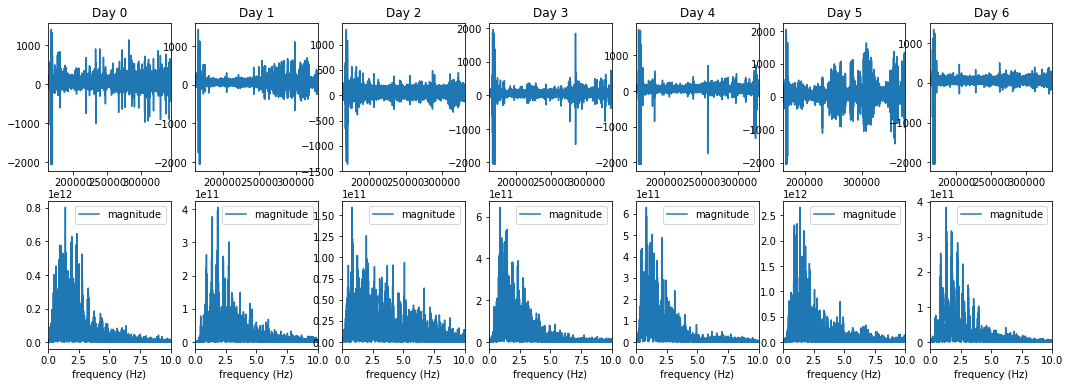

In [46]:
#Graph unlabelled dataset
fig, axes = plt.subplots(nrows=2, ncols=7,figsize=(18,6,))
for i in range(len(week1_datasets)):
    plot_chart(i,'unlabeled')


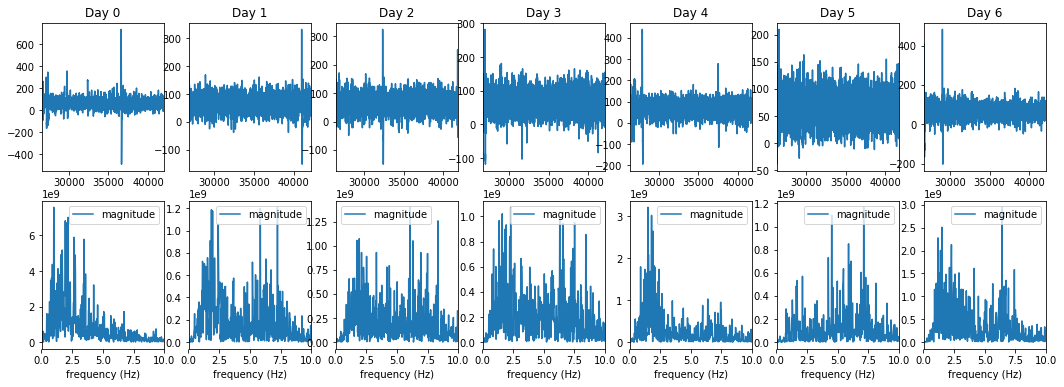

In [44]:
#Plot the same for math task
fig, axes = plt.subplots(nrows=2, ncols=7,figsize=(18,6,))
for i in range(len(week1_datasets)):
    plot_chart(i,'math\d')

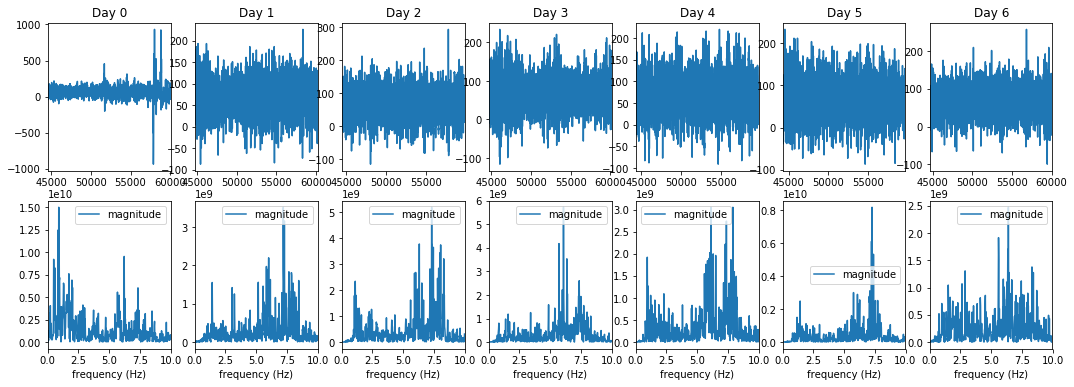

In [45]:
#Repeat the same for music
fig, axes = plt.subplots(nrows=2, ncols=7,figsize=(18,6,))
for i in range(len(week1_datasets)):
    plot_chart(i,'music')


#### Findings
1. Unlabeled task
    Across the time domain, the graphs looks completely different. On the frequency domain, the variation is not as obvious and somehow adopts a similar shape.
2. Math Task -
    Characterized with a spike each day although at different times.
3. Music Task
    Day 0 looks very different from all other days. Day 1 and Day 2 look very similar.
    
#### Preliminary Conclusion
The maths task seems to have less variation at face value just by looking at the signals. A lot more analysis needs to be done to confirm this claim.


#### Future  work
Need to explore more 

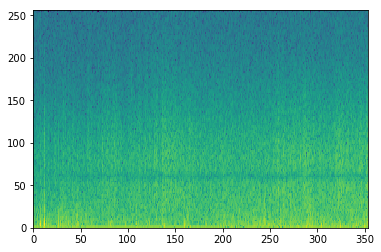

In [69]:
from matplotlib.pyplot import specgram

NFFT = 256
FS= 512
dataset = week1_datasets[0]
data_un =dataset[dataset['event name'] == 'unlabeled'][' Value']
data_music =dataset[dataset['event name'] == 'music'][' Value']
data_relax =dataset[dataset['event name'] == 'relax'][' Value']
#fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(15,5))

plt.specgram(data_un, NFFT=NFFT, Fs=FS)
# plt.specgram(data_music, NFFT=NFFT, Fs=FS)
# plt.specgram(data_relax, NFFT=NFFT, Fs=FS)
plt.show()